## [Chapter 1](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb)

Notes and exercises from Cam Davidson's *[Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)*.

In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from IPython.display import display
from scipy import stats
from scipy.misc import comb as nCk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb

np.random.seed(865)

'Done'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'Done'

### Mandatory coin-flip example

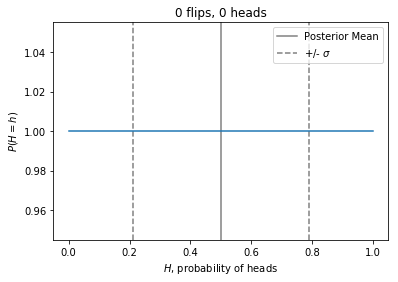

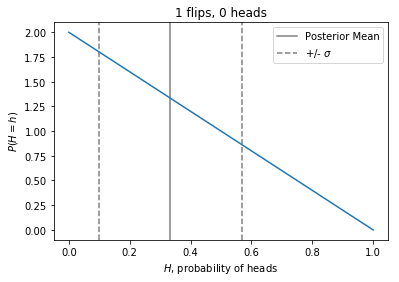

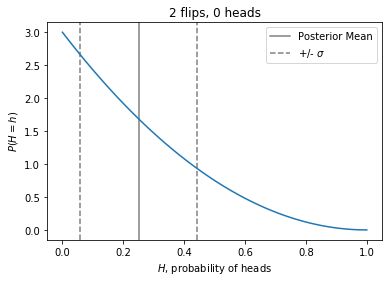

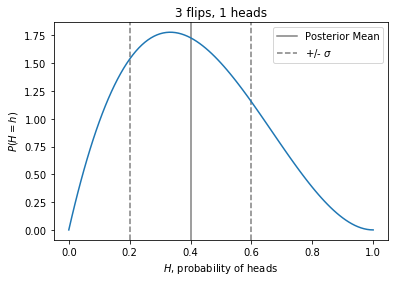

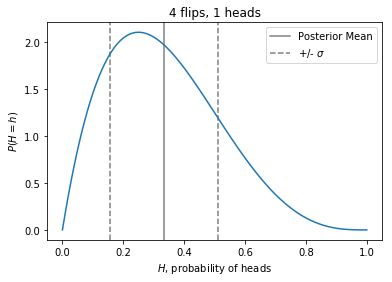

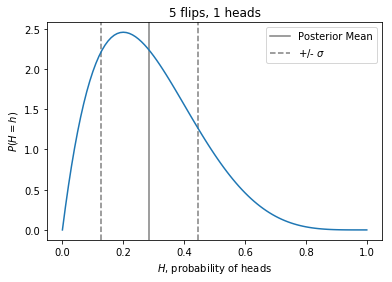

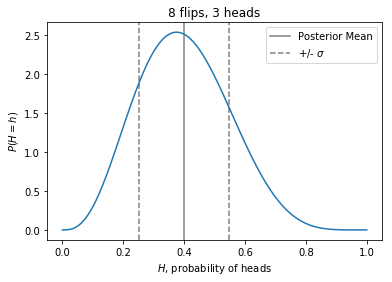

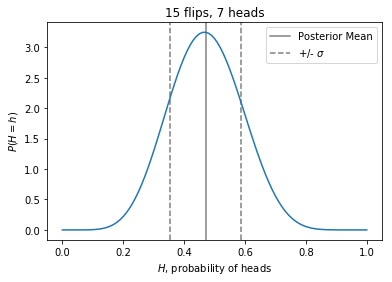

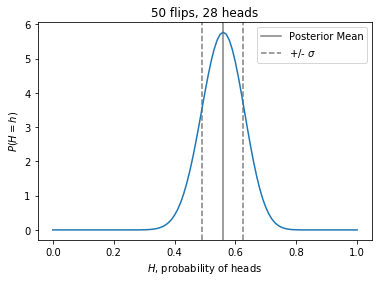

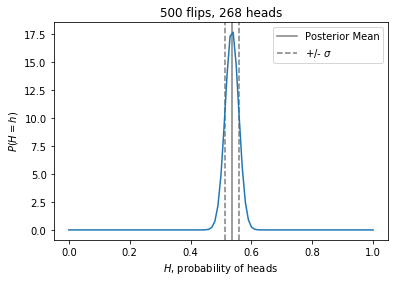

In [3]:
# Number of flips for each figure.
n_flips = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]

# Generate random coin flips.
# They get generated once and re-used below for the various values in n_flips.
flips = np.random.binomial(1, p=0.5, size=n_flips[-1])

# Values used to evalute PDF for plotting.
X = np.linspace(0, 1, 101)

for k, N in enumerate(n_flips):

    # Count the number of heads and tails up to the Nth trial.
    heads = flips[:N].sum()
    tails = N - heads
    
    # The posterior is expressed by the Beta distribution using 
    # the numbers of heads and tails as alpha and beta. This is a
    # bit of a shortcut, which basically assumes that the prior 
    # was uniform, or equivalently, Beta(1,1).
    alpha = 1 + heads
    beta = 1 + tails
    post = stats.beta(alpha, beta)
    
    # Evaluate the posterior at the previously-defined values of X.
    y = post.pdf(X)
    
    # Plot the posterior with its mean and standard deviations.
    plt.title('%d flips, %d heads' % (N, heads))
    plt.axvline(post.mean(), color='gray', label='Posterior Mean')
    plt.axvline(post.mean() - post.std(), color='gray', linestyle='--', label='+/- $\sigma$')
    plt.axvline(post.mean() + post.std(), color='gray', linestyle='--')
    plt.plot(X, y)
    plt.xlabel('$H$, probability of heads')
    plt.ylabel('$P(H = h)$')
    plt.legend()
    plt.show()

## Are there bugs in my code?

Hypotheses:

- $A$ : no bugs in code
- $B$ : bugs in code

Evidence:

- $X$ : code passed all tests

Compute posterior analytically:

(See book for steps)

$P(A | X) = \frac{2p}{1 + p}$, where prior $P(A) = p$ and we assume $P(X | B) = 0.5$.

Compute posterior as a function of prior, $P(A)$:

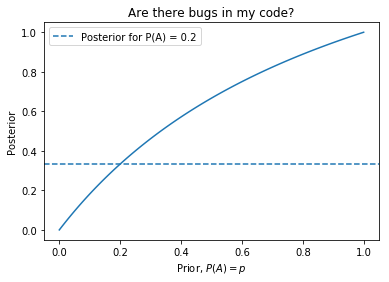

Prior and Posterior probability of bugs present:
P(A) = 0.2
P(A | X) = 0.3
P(B) = 1 - P(A) = 0.8
P(B | X) = 1 - P(A | X) = 0.7


In [17]:
# Posterior for the priors above.
post = lambda P: 2 * P / (1 + P)

# Various priors for p.
P = np.linspace(0, 1, 101)

# An example prior P(A).
prA = 0.2

# Plot the posterior evaluated at all priors, with a line at prior P(A) = prA.
plt.plot(P, post(P))
plt.axhline(post(prA), label='Posterior for P(A) = %.1lf' % prA, linestyle='--')
plt.xlabel('Prior, $P(A) = p$')
plt.ylabel('Posterior')
plt.title('Are there bugs in my code?')
plt.legend()
plt.show()

# How do the prior and posterior changed assumign prior P(A) = 0.2?
# Shows the same information as the figure titled "Prior and Posterior probability of bugs present".
print('Prior and Posterior probability of bugs present:')
print('P(A) = %.1lf' % prA)
print('P(A | X) = %.1lf' % post(prA))
print('P(B) = 1 - P(A) = %.1lf' % (1 - prA))
print('P(B | X) = 1 - P(A | X) = %.1lf' % (1 - post(prA)))

## Probabilistic Program for Cell Phone Usage

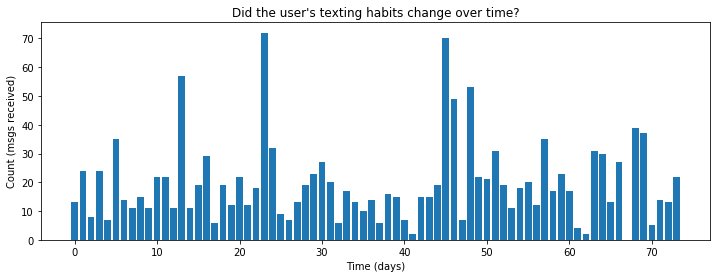

In [21]:
counts = np.loadtxt('davidson/Chapter1_Introduction/data/txtdata.csv')
plt.figure(figsize=(12,4))
plt.bar(np.arange(len(counts)), counts)
plt.xlabel('Time (days)')
plt.ylabel('Count (msgs received)')
plt.title('Did the user\'s texting habits change over time?')
plt.show()

In [98]:
import pymc3 as pm

with pm.Model() as model:
    
    # Alpha parameterizes the exponential distribution from
    # from which both lambdas are sampled. We define it as
    # the inverse of the mean of the count data.
    alpha = 1 / counts.mean()
    
    # Lambda's 1 and 2 parameterize the two Poisson distributions
    # from which the counts are sampled.    
    lam1 = pm.Exponential('lam1', alpha)
    lam2 = pm.Exponential('lam2', alpha)
    
    # Tau defines the day at which the Poisson distributions switch.    
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(counts) - 1)
    
    # Define a function lam_switch which will return lam1 or lam2 
    # depending on the current value of tau.
    idx = np.arange(len(counts))
    lam_switch = pm.math.switch(tau > idx, lam1, lam2)
    
    # Combine the observed values with the data generation scheme
    # (in one step). This poisson variable will use whichever lambda
    # gets returned from lam_switch.
    obs = pm.Poisson('obs', lam_switch, observed=counts)
    
    # Run metropolis-hastings sampling. The trace is a dictionary
    # containing posteriors for each random variable defined above.
    # This took a while on the first run.. possibly because it is
    # compiling a Theano graph under the hood?
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lam2_log__]
>Metropolis: [lam1_log__]
100%|██████████| 15000/15000 [00:11<00:00, 1346.72it/s]
The number of effective samples is smaller than 25% for some parameters.


Extract the posterior samples from the trace and plot them.

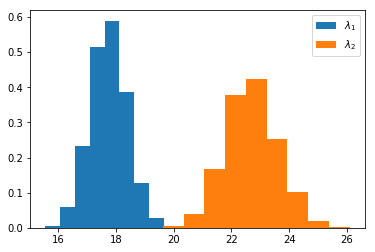

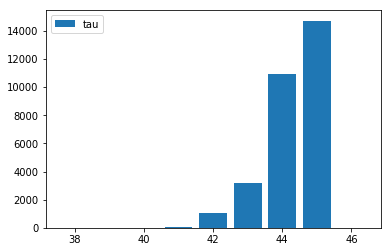

In [99]:
plt.hist(trace['lam1'], label='$\lambda_1$', density=True)
plt.hist(trace['lam2'], label='$\lambda_2$', density=True)
plt.legend()
plt.show()

tau = Counter(trace['tau'])
plt.bar(tau.keys(), tau.values(), label='tau')
plt.legend()
plt.show()

Use the posterior distributions to plot the expected number of messages at each day.

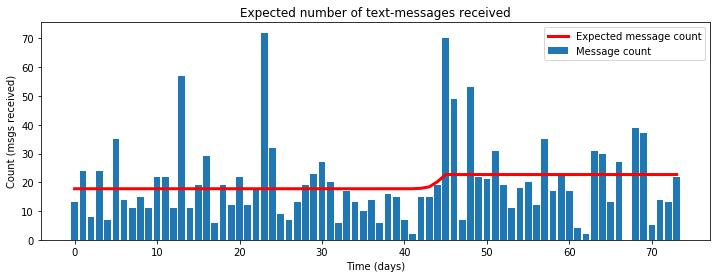

In [100]:

expected_counts = np.zeros(len(counts))

for day in range(len(counts)):    
    
    # For each day, the samples of tau will give a mask of indices where 
    # lambda 1 or lambda 2 should be used to compute the day's expectation.
    lam1_msk = day < trace['tau']
    lam2_msk = ~lam1_msk
    
    # The two masks have no overlap.
    assert set(lam1_msk * lam2_msk) == {False}

    # The expected count is an average of the weighted sum of lambdas by their masks.
    # There's perhaps a more efficient way to do this, but I think this is easiest to understand.
    exps = (trace['lam1'] * lam1_msk) + (trace['lam2'] * lam2_msk)
    expected_counts[day] = exps.mean()

plt.figure(figsize=(12,4))
plt.bar(range(len(counts)), counts, label='Message count')
plt.plot(expected_counts, color='red', linewidth=3, label='Expected message count')
plt.title('Expected number of text-messages received')
plt.xlabel('Time (days)')
plt.ylabel('Count (msgs received)')
plt.legend()
plt.show()

## Exercises

1) What is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

In [101]:
print('Mean lam1 = %.3lf' % trace['lam1'].mean())
print('Mean lam2 = %.3lf' % trace['lam2'].mean())
print('Mean lam1, lam2 = %.3lf' % ((trace['lam1'] + trace['lam2']) / 2).mean())

Mean lam1 = 17.753
Mean lam2 = 22.692
Mean lam1, lam2 = 20.223


2) What is the expected percentage increase in text-message rates?

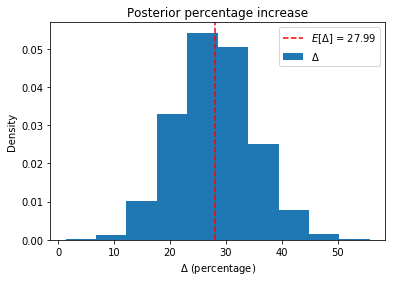

In [102]:
d = (trace['lam2'] - trace['lam1']) / trace['lam1'] * 100
plt.hist(d, label='$\Delta$', density=True)
plt.axvline(d.mean(), label='$E[\Delta]$ = %.2lf' % d.mean(), color='red', linestyle='--')
plt.title('Posterior percentage increase')
plt.xlabel('$\Delta$ (percentage)')
plt.ylabel('Density')
plt.legend()
plt.show()

3) What is the mean of $\lambda_1$ given that we know $\tau < 45$? That is, suppose we have been given new information that th echange in behavior occurred prior to day 45. What is the expected value of $\lambda_1$ now?

In [103]:
msk = trace['tau'] < 45
print('Mean value of lam1 given tau < 45 = %.3lf' % trace['lam1'][msk].mean())

Mean value of lam1 given tau < 45 = 17.753
